<a href="https://colab.research.google.com/github/Derrc/Reinforcement-Learning/blob/main/colab/mujuco_ppo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf

In [ ]:
!pip install gymnasium
!pip install free-mujoco-py

In [ ]:
import mujoco_py
import gymnasium as gym
import torch
import torch.nn as nn
from torch.distributions import Normal
import numpy as np
import random
import os
import matplotlib.pyplot as plt

from google.colab import drive

# mount google drive for saving checkpoints
drive.mount('/content/gdrive')

In [4]:
# ENVS
MOUNTAIN_CAR = 'MountainCarContinuous-v0'
ANT = 'Ant-v2'
CHEETAH = 'HalfCheetah-v2'

In [11]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.layers = nn.Sequential(
            layer_init(nn.Linear(state_dim, 128)),
            nn.ReLU(),    
            layer_init(nn.Linear(128, 1), std=1.0)
        )

    def forward(self, x):
        x = self.layers(x)
        return x


class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, action_low, action_high):
        super().__init__()
        self.layers = nn.Sequential(
            layer_init(nn.Linear(state_dim, 64)),
            nn.Tanh(),    
            layer_init(nn.Linear(64, 64)),  
            nn.Tanh(),      
            layer_init(nn.Linear(64, action_dim), std=0.01)
        )
        self.action_dim = action_dim
        self.action_low = action_low
        self.action_high = action_high
        self.logstd = nn.Parameter(torch.zeros(action_dim))

    def forward(self, x): 
        mu = self.layers(x)
        std = torch.exp(self.logstd)
        # mean, std
        return mu, std

    def get_log_probs(self, state, actions):
        mu, std = self.forward(state)
        dist = Normal(mu, std)
        log_prob = dist.log_prob(actions)
        entropy = dist.entropy()

        return log_prob.sum(1), entropy.sum(1)

    def get_action(self,state):
        mu, std = self.forward(state)
        dist = Normal(mu, std)
        action = torch.clamp(dist.sample(), self.action_low, self.action_high)

        log_prob_action = dist.log_prob(action)
        return action, log_prob_action.sum(0)

In [9]:
class PPOAgent():
    def __init__(self, env_name, **hyperparameters):
        self.env = gym.make(env_name)
        self.obs_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.shape[0]
        self.action_low = self.env.action_space.low[0]
        self.action_high = self.env.action_space.high[0]

        self.init_hyperparameters(hyperparameters)

        self.actor = Actor(self.obs_dim, self.action_dim, self.action_low, self.action_high).to(self.device)
        self.critic = Critic(self.obs_dim).to(self.device)

        self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=self.actor_lr, eps=1e-6)
        self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=self.critic_lr)

        self.actor_path = '/content/gdrive/My Drive/RL/Mujuco/models/mujuco_ppo_actor.pth'
        self.critic_path = '/content/gdrive/My Drive/RL/Mujuco/models/mujuco_ppo_critic.pth'


    def init_hyperparameters(self, hyperparameters):
        # hyperparameters taken from PPO paper for Mujuco Envs
        self.total_steps = 2000000
        self.batch_size = 2048
        self.minibatch_size = 64
        self.discount = 0.99
        self.entropy_coef = 0.01
        self.policy_clip = 0.2
        self.kl_target = 0.01
        self.max_grad_norm = 0.5
        self.gae_param = 0.95
        self.optim_epochs = 10
        self.actor_lr = 3e-4
        self.critic_lr = 3e-4
        self.seed = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        for param, val in hyperparameters.items():
            exec('self.' + param + ' = ' + str(val))

        if self.seed != None:
            torch.manual_seed(self.seed)
            np.random.seed(self.seed)
            random.seed(self.seed)

    def load(self):
        self.actor.load_state_dict(torch.load(self.actor_path))
        self.critic.load_state_dict(torch.load(self.critic_path))

    def save(self):
        torch.save(self.actor.state_dict(), self.actor_path)
        torch.save(self.critic.state_dict(), self.critic_path)


In [7]:
def gae(values, next_values, rewards, dones, discount, gae_param):
    advantages = torch.zeros(len(rewards) + 1)

    for i in reversed(range(len(rewards)-1)):
        nonterminal = 1 - dones[i]
        delta = rewards[i] + discount * next_values[i] - values[i]
        advantages[i] = delta + (nonterminal * discount * gae_param * advantages[i+1])

    advantages = advantages[:len(rewards)]
    return advantages

def clipped_loss(ratio, advantages, policy_clip):
    # no_clip = torch.clamp(ratio * advantages, min=1e3, max=None)
    no_clip = ratio * advantages
    clip = torch.clamp(ratio, 1 - policy_clip, 1 + policy_clip) * advantages
    return torch.min(no_clip, clip).mean()


def plot(global_step, rewards, entropy_loss):
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.plot(rewards)
    plt.title(f'Rewards at Step {global_step}')
    plt.subplot(132)
    plt.plot(entropy_loss)
    plt.title(f'Entropy Loss at Step {global_step}')
    plt.show()


In [12]:
def train(current_update):
    agent = PPOAgent(ANT, seed=10)

    b_size = agent.batch_size
    device = agent.device
    env = agent.env

    # load models if exists
    if os.path.exists(agent.actor_path):
        agent.load()

    # storage tensors
    obs = torch.zeros((b_size, agent.obs_dim)).to(device)
    next_obs = torch.zeros((b_size, agent.obs_dim)).to(device)
    actions = torch.zeros((b_size, agent.action_dim)).to(device)
    log_probs = torch.zeros((b_size)).to(device)
    rewards = torch.zeros(b_size).to(device)
    dones = torch.zeros(b_size).to(device)

    global_step = 0
    total_rewards, total_entropy = [], []
    num_updates = agent.total_steps // b_size
    num_minibatches = b_size // agent.minibatch_size
    ob = torch.tensor(env.reset()[0], dtype=torch.float32)

    for update in range(current_update, num_updates):
        # anneal lr of optimizers
        rate = 1.0 - (update - 1.0) / num_updates
        lr = rate * agent.actor_lr
        agent.actor_optim.param_groups[0]['lr'] = lr
        agent.critic_optim.param_groups[0]['lr'] = lr

        # run trajectories -> generate batch
        for step in range(b_size):
            global_step += 1

            with torch.no_grad():
                action, log_prob = agent.actor.get_action(ob)

            next_ob, reward, terminated, truncated, info = env.step(action)
            next_ob = torch.tensor(next_ob, dtype=torch.float32)

            obs[step] = ob
            next_obs[step] = next_ob
            actions[step] = action
            log_probs[step] = log_prob
            rewards[step] = reward
            dones[step] = torch.tensor(np.logical_or(terminated, truncated), dtype=torch.float32)

            ob = next_ob.clone()
            if terminated or truncated:
                ob = torch.tensor(env.reset()[0], dtype=torch.float32)

        # estimate returns and advantages using GAE
        with torch.no_grad():
            values = agent.critic(obs)
            next_values = agent.critic(next_obs)
            advantages = gae(values, next_values, rewards, dones, agent.discount, agent.gae_param)
            returns = advantages + values.squeeze(1)

        # update policy and value function using mini-batches
        mb_size = agent.minibatch_size
        b_indices = np.arange(b_size)
        for step in range(agent.optim_epochs):
            np.random.shuffle(b_indices)
            for i in range(num_minibatches):
                start, end = mb_size * i, mb_size * (i+1) # inclusive, non-inclusive
                mb_indices = b_indices[start:end]
                mb_obs = obs[mb_indices]
                mb_actions = actions[mb_indices]
                mb_lps = log_probs[mb_indices]
                mb_returns = returns[mb_indices]
                mb_advantages = advantages[mb_indices]
                # normalize advantages every mini-batch
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

                new_lps, entropy = agent.actor.get_log_probs(mb_obs, mb_actions)
                new_values = agent.critic(mb_obs)
                log_ratio = new_lps - mb_lps
                ratio = torch.exp(log_ratio)

                # implement value clipping
                value_loss = 0.5 * (new_values - mb_returns).pow(2).mean()
                agent.critic_optim.zero_grad()
                value_loss.backward()
                nn.utils.clip_grad_norm_(agent.critic.parameters(), agent.max_grad_norm)
                agent.critic_optim.step()

                entropy_loss = entropy.mean()

                policy_loss = -clipped_loss(ratio, mb_advantages, agent.policy_clip)
                agent.actor_optim.zero_grad()
                policy_loss.backward()
                nn.utils.clip_grad_norm_(agent.actor.parameters(), agent.max_grad_norm)
                agent.actor_optim.step()

                # plotting
                total_rewards.append(np.sum(rewards.cpu().numpy()))
                total_entropy.append(entropy_loss.detach().cpu().numpy())


        if update % 5 == 0:
            plot(global_step, total_rewards, total_entropy)
            agent.save()

/usr/local/lib/python3.8/dist-packages/gymnasium/envs/registration.py:577: UserWarning: WARN: The environment Ant-v2 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gymnasium/envs/mujoco/mujoco_env.py:183: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gymnasium/utils/passive_env_checker.py:268: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'torch.Tensor'>
  logger.warn(


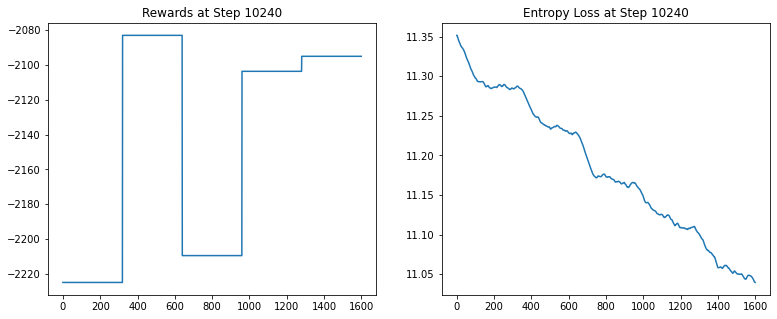

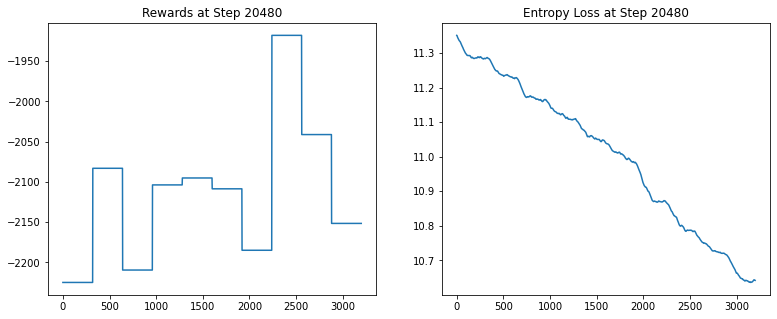

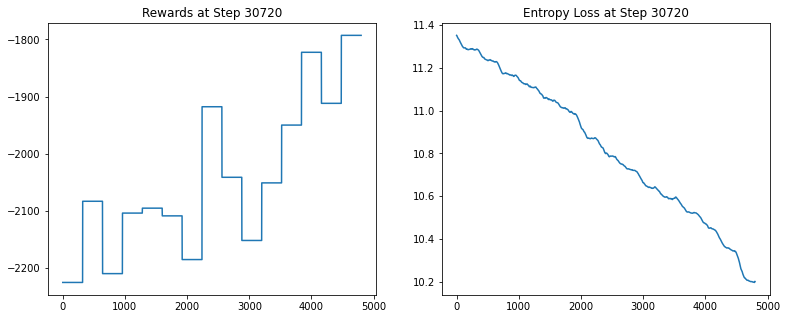

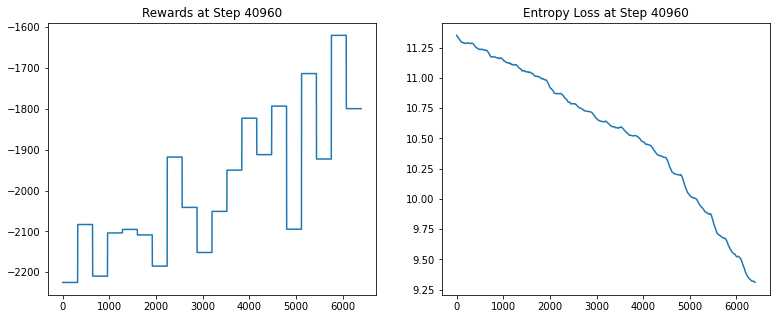

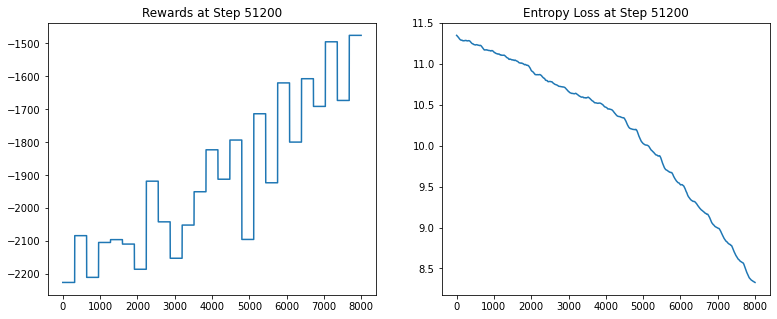

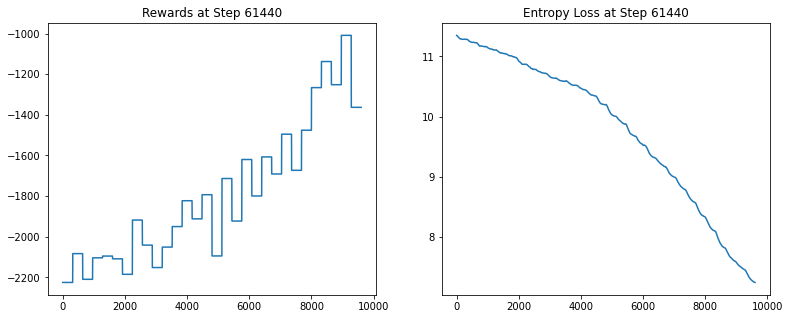

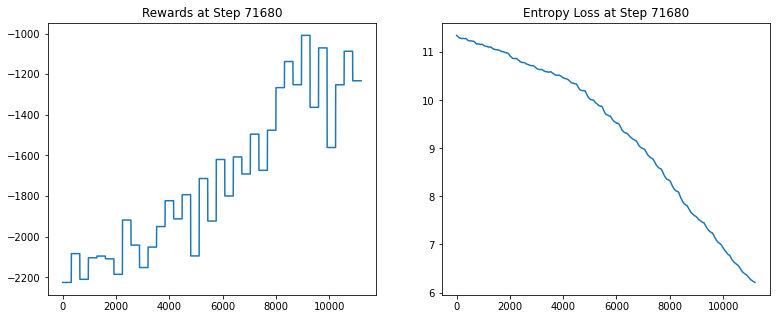

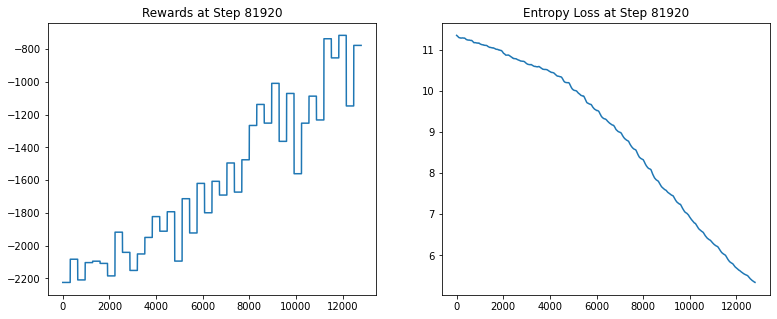

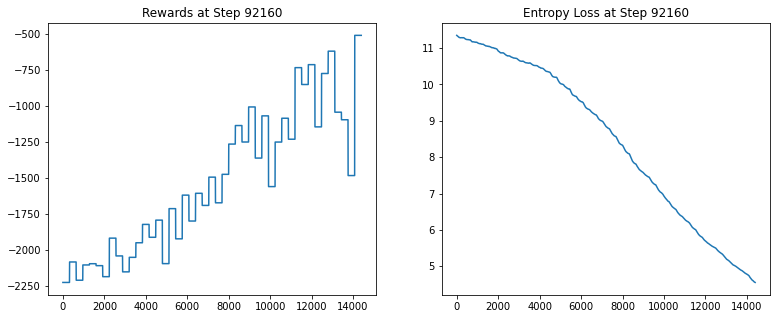

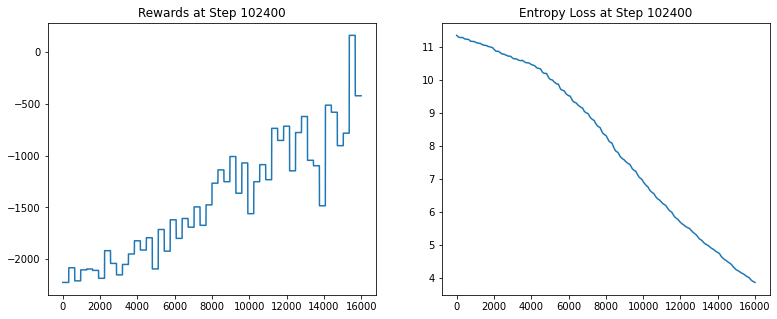

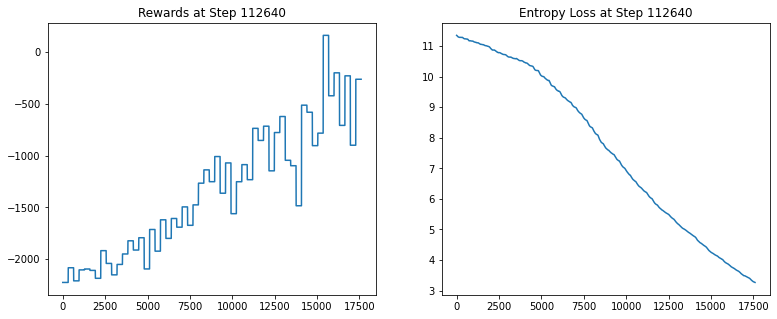

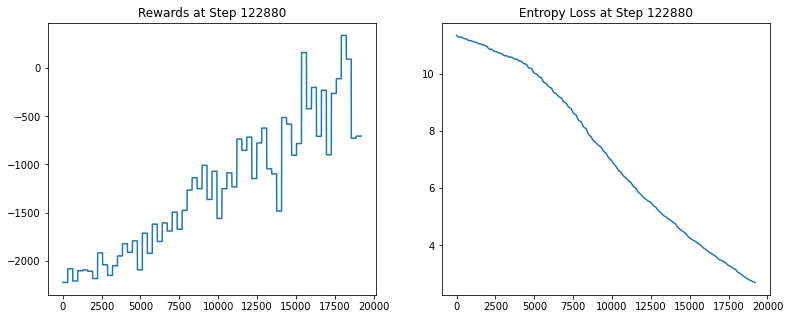

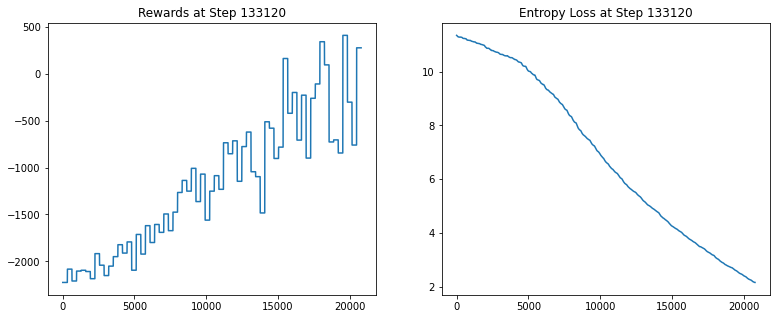

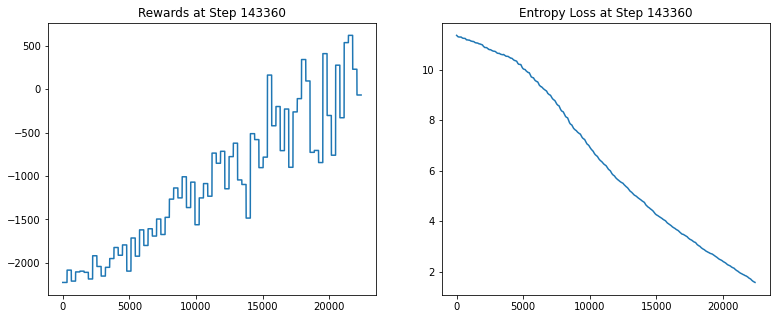

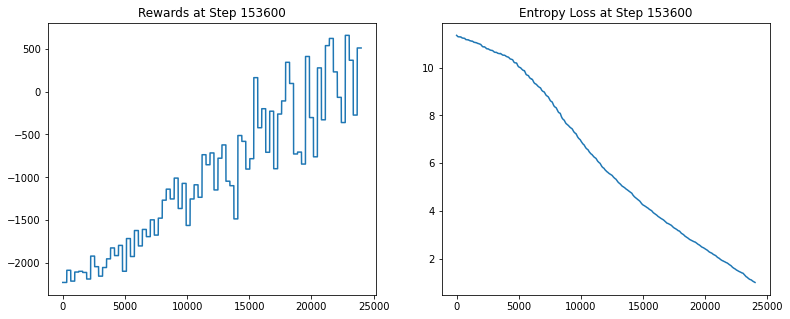

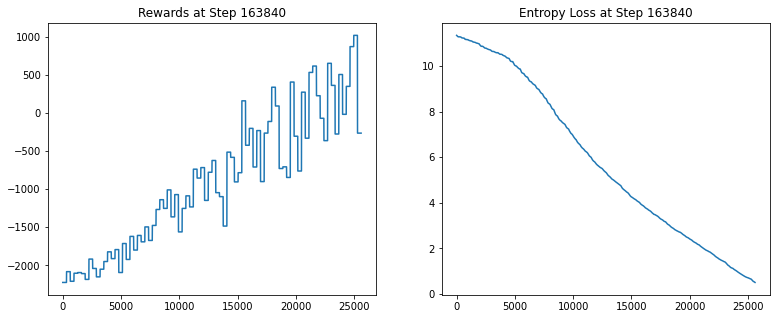

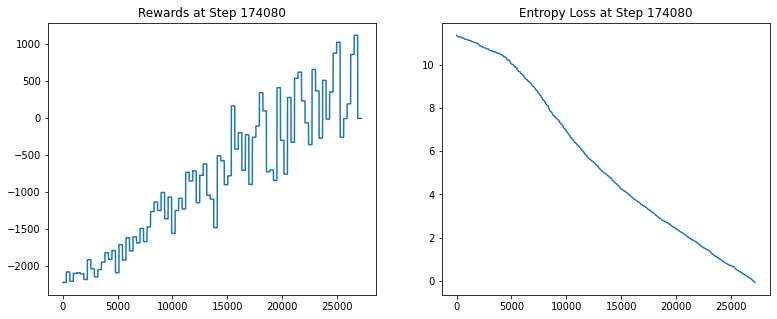

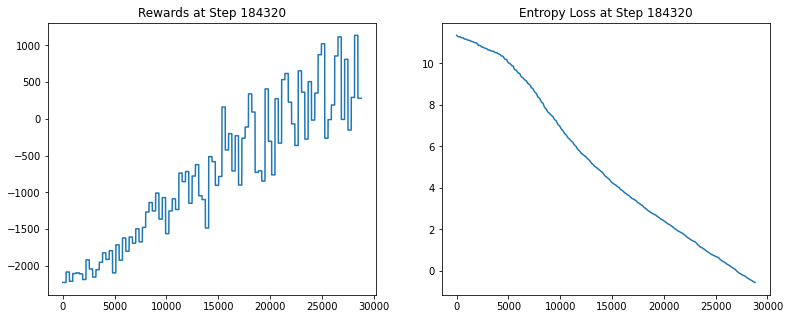

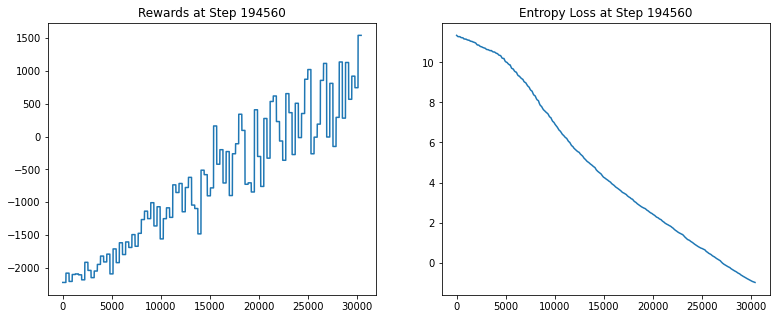

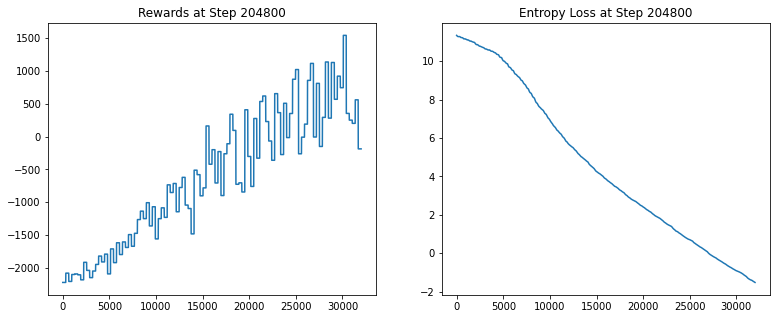

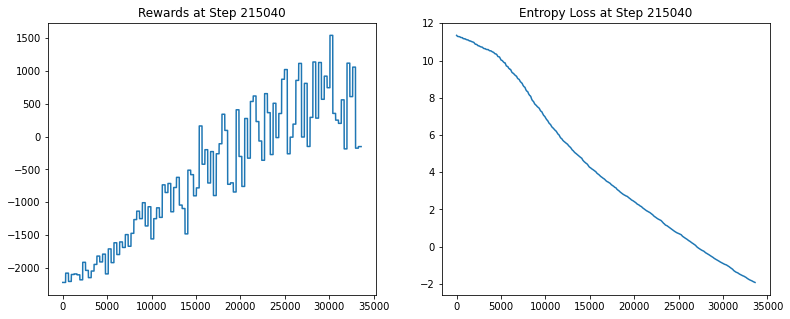

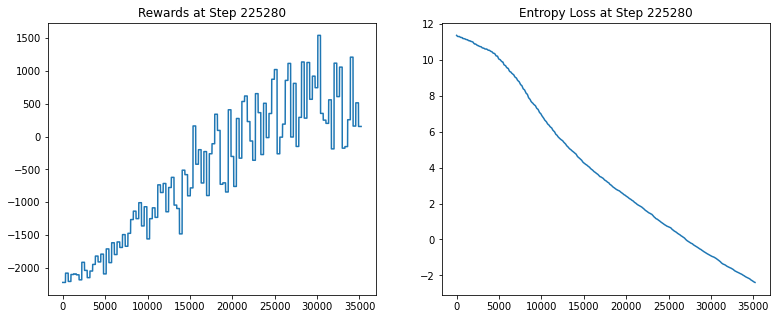

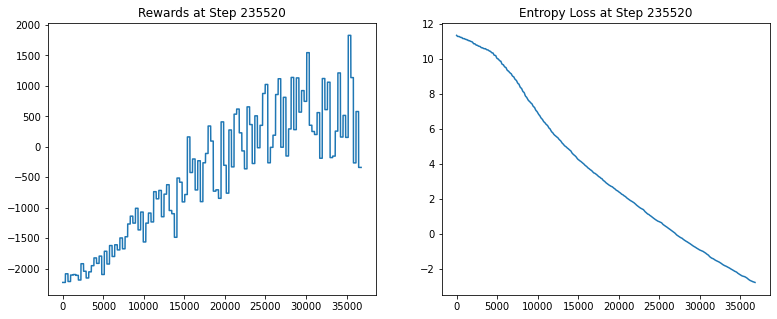

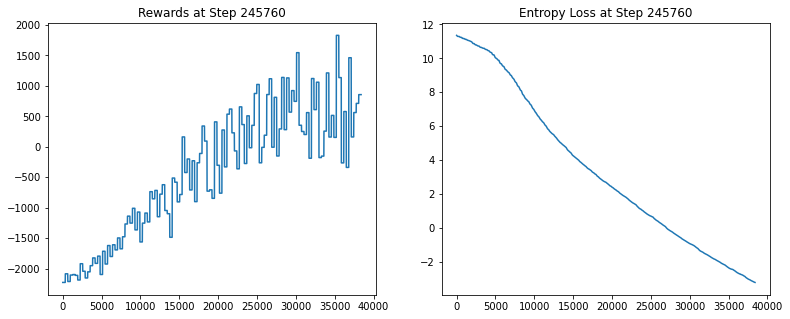

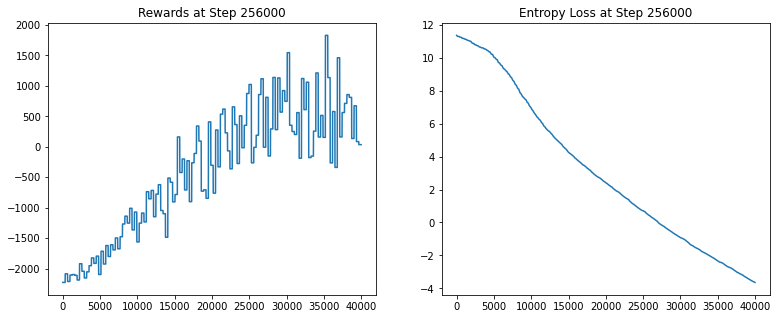

ValueError: ignored

In [13]:
current_update = 1
train(current_update)